# Récupération du DEM

start download from http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs?service=WCS&request=GetCoverage&version=1.0.0&coverage=TINItaly_1_1%3Atinitaly_dem&CRS=EPSG%3A32632&BBOX=747547.4962%2C4721805.0088%2C901147.4962%2C4875405.0088&format=geotiff&width=2048&height=2048
CRS : EPSG:32632
Taille : 2048 2048
Bbox : BoundingBox(left=747547.4962, bottom=4721805.0088, right=901147.4962, top=4875405.0088)


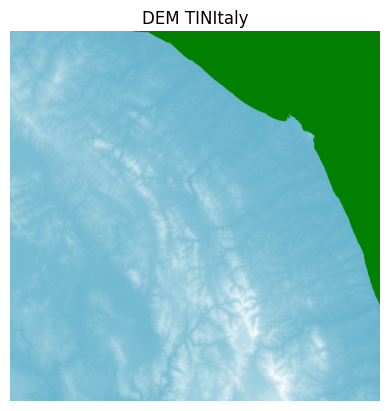

In [2]:
from pyslam.io.maps import DEM

dem = DEM()
dem.download()

dem.display(title="DEM TINItaly", to_file=False)


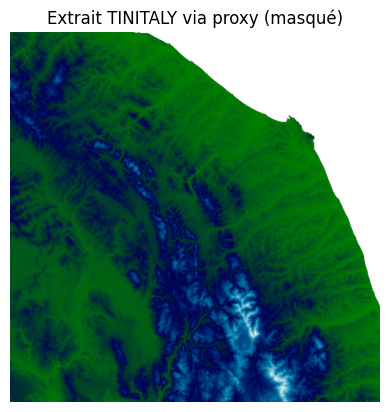

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Faire un masque avec les valeurs nulles ou NaN
mask = np.isnan(dem.array) | (dem.array == -9999)

# Appliquer le masque
dem_array_masked = np.ma.masked_array(dem.array, mask=mask)
# Affichage du DEM avec le masque      
plt.imshow(dem_array_masked, cmap='ocean')
plt.axis('off')
plt.title("Extrait TINITALY via proxy (masqué)")
plt.show()  


Legend URL: https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2012_WM/MapServer/WMSServer?request=GetLegendGraphic%26version=1.3.0%26format=image/png%26layer=Corine_Land_Cover_2012_raster59601
(534, 828) P


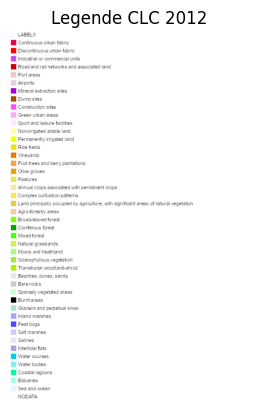

Nombre de couleurs : 216
10 Premières couleurs : [(0, 0, 0), (51, 0, 0), (102, 0, 0), (153, 0, 0), (204, 0, 0), (255, 0, 0), (0, 51, 0), (51, 51, 0), (102, 51, 0), (153, 51, 0)]


In [6]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from urllib.parse import urlencode
import urllib

from IPython.display import HTML
import pandas as pd


def get_and_plot_clc_legend():
    """Récupère et affiche la légende du CLC 2012."""
    # La légende est une image PNG
    legend_url = 'https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2012_WM/MapServer/WMSServer?request=GetLegendGraphic%26version=1.3.0%26format=image/png%26layer=Corine_Land_Cover_2012_raster59601'

    print("Legend URL:", legend_url)
    
    # Utiliser un proxy si nécessaire
    # Si vous n'avez pas besoin de proxy, commentez les lignes suivantes
    proxy = "http://irproxy:8082"  
    proxy_handler = urllib.request.ProxyHandler({
        'http': proxy,
        'https': proxy
    })
    opener = urllib.request.build_opener(proxy_handler)

    with opener.open(legend_url) as response:
        coverage_data = response.read()

        
    legend = Image.open(BytesIO(coverage_data)).convert("P")
    print(legend.size, legend.mode)
    plt.imshow(legend)
    plt.axis('off')
    plt.title("Legende CLC 2012")
    plt.show()

    return legend


def get_palette(image):
    if image.mode == 'P':
        palette = image.getpalette()
        color_table = []
        for i in range(0, len(palette), 3):
            color = tuple(palette[i:i+3])
            if color not in color_table:
                color_table.append(color)
        filtered_colors = sorted(color_table, key=lambda x: (x[2], x[1], x[0]))
        #filtered_colors = [color for color in sorted(set(color_table))]  
        print("Nombre de couleurs :", len(filtered_colors))
        print("10 Premières couleurs :", [filtered_colors[i] for i in range(10)])

        return filtered_colors

legend = get_and_plot_clc_legend()
legend_palette = get_palette(legend)



Style name:  Corine Land Cover 2012 raster
dict_keys(['title', 'legend', 'legend_width', 'legend_height', 'legend_format'])


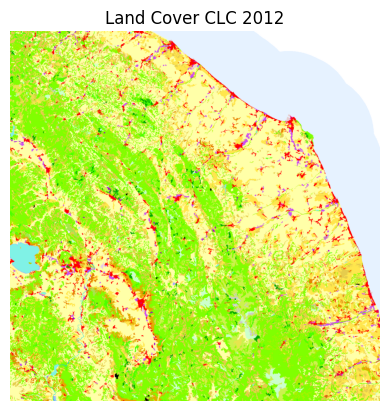

In [1]:

from pyslam.io.maps import LandCover

land_cover = LandCover()
land_cover.download()

land_cover.display(title="Land Cover CLC 2012", to_file=False)


Le fichier /work/lecomtje/Repositories/rains/pyslam/data/litology_italy.gpkg existe déjà.
Nombre de géométries : 19
CRS : EPSG:4326
Bbox : [ 6.5465398  35.49129252 18.52094282 47.09323084]
Colonnes : Index(['cat', 'l3_mix', 'code', 'description', 'geometry'], dtype='object')
Nombre de géométries après clipping : 18
Bbox après clipping : [12.01789378 42.60893581 13.99670457 43.92241251]
Colonnes après clipping : Index(['cat', 'l3_mix', 'code', 'description', 'geometry'], dtype='object')


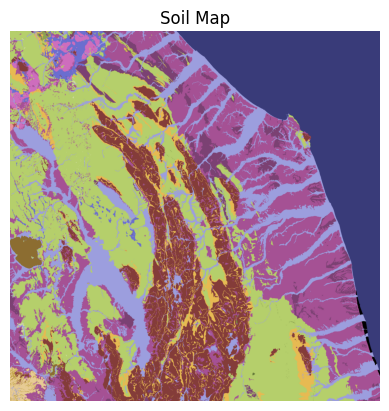

In [1]:
from pyslam.io.maps import Soil

soil = Soil()
soil.download()
soil.display(title="Soil Map", to_file=False)


In [ ]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS, ASYNCHRONOUS
import numpy as np
import pandas as pd

token = "bdfWYR9mSnsAOUy2cVfiGe_AIlpMby_JkJBgMCXI0_IyLSwjmmSiNlbpG1yBjSlaNUVfook4_iXfTZfBmuYCEg=="
org = "IFPEN"
url = "http://10.25.11.36:8086"

time_start = "2013-01-01T00:00:00Z"
time_stop = "2015-01-01T00:00:00Z"


client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()
query = """from(bucket: "rainfall")
  |> range(start: {}, stop: {})
  |> filter(fn: (r) => r["_measurement"] == "rainfall")
  |> filter(fn: (r) => r["_field"] == "Precipitazione")  // ou "Neve"
  |> drop(columns: ["Codice_stazione"])
  |> aggregateWindow(every: 2d, fn: sum, createEmpty: false)
  |> pivot(rowKey: ["_time"], columnKey: [ "_field", "Codice_sensore"], valueColumn: "_value")
  |> yield(name: "sum")
  """

# Obtenir directement un DataFrame
df = query_api.query_data_frame(query.format(time_start, time_stop))
df.head()


In [ ]:
df["_time"] = pd.to_datetime(df["_time"])
df = df.set_index("_time")

print(df.columns)

In [ ]:
import matplotlib.pyplot as plt
capteur = 2988


plt.figure(figsize=(12, 5))
plt.plot(df.index, df[f"Precipitazione_{capteur}"], label="Précipitations")
plt.xlabel("Date")
plt.ylabel("Précipitation (somme sur 2 jours)")
plt.title(f"Évolution des précipitations - Capteur {capteur}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import re
import matplotlib.pyplot as plt

def parse_offset(delai):
    match = re.fullmatch(r"(\d+)([ymwdh])", delai)
    if not match:
        raise ValueError("Délai invalide : utiliser des formats comme '1y', '6m', '30d'")
    value, unit = match.groups()
    value = int(value)
    if unit == "y":
        return pd.DateOffset(years=value)
    elif unit == "m":
        return pd.DateOffset(months=value)
    elif unit == "w":
        return pd.Timedelta(weeks=value)
    elif unit == "d":
        return pd.Timedelta(days=value)
    elif unit == "h":
        return pd.Timedelta(hours=value)
    else:
        raise ValueError("Unité non reconnue")
    
def add_precipitation(client, dfita, rain_start="2013-01-01T00:00:00Z", delai="1m"):
    """
    Ajoute la colonne 'rain' au DataFrame dfita avec les précipitations pour chaque station.
    Les paramètres rain_start et delai définissent la période de récupération des données.
    Le paramètre delai doit être au format '1y', '6m', '30d', '1w', '12h' etc.
    """
    rain_stop = pd.to_datetime(rain_start) + parse_offset(delai)
       
    query = """from(bucket: "rainfall")
        |> range(start: {}, stop: {})
        |> filter(fn: (r) => r._measurement == "rainfall")
        |> filter(fn: (r) => r._field == "Precipitazione")
        |> filter(fn: (r) => r.Codice_sensore == "{}")
        |> sum()"""
    
    dfita = dfita.copy()  # Ensure we are working on a copy to avoid SettingWithCopyWarning
    dfita["rain"] = np.nan
    query_api = client.query_api()
    for id in dfita["id"]:
        tables = query_api.query(query.format(rain_start, rain_stop.strftime('%Y-%m-%dT%H:%M:%SZ'), id))
        if len(tables) > 0:
            record = tables[0].records[0]
            dfita.loc[dfita["id"] == id, "rain"] = record.get_value()

    dfita = dfita.dropna(subset=["rain"])
    dfita = dfita[dfita['rain'] > 0]
    return dfita




load stations
Nombre de géométries : 247
CRS : EPSG:4326
Bbox : [12.19 42.55 13.89 44.05]
Colonnes : Index(['id', 'name', 'start', 'end', 'geometry'], dtype='object')
Nombre de géométries : 242
CRS : EPSG:4326
Bbox : [12.19 42.63 13.89 43.91]
Colonnes : Index(['id', 'name', 'start', 'end', 'geometry'], dtype='object')
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 526.8305664109104
Full Sill: 1214.8462271770038
Range: 51107.08968065897
Nugget: 688.0156607660934 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Krigeage terminé.


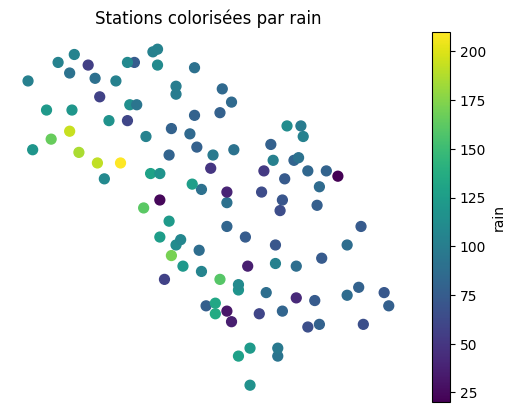

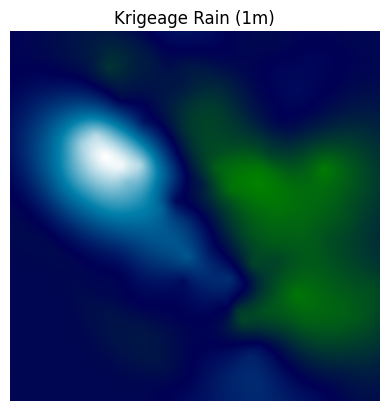

In [1]:
from pyslam.io.maps import Rain
import matplotlib.pyplot as plt

def draw_station_dataframe(df_stations_clip, column_name):
    x = df_stations_clip.geometry.x
    y = df_stations_clip.geometry.y
    values = df_stations_clip[column_name]
    
    plt.scatter(x, y, c=values, cmap='viridis', s=50)  # 'c' pour coloriser, 'cmap' pour la palette de couleurs
    plt.colorbar(label=column_name)  # Ajouter une barre de couleur
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Stations colorisées par {column_name}")
    plt.axis('off')  # Pour ne pas afficher les axes
    plt.show()


rain_1m = Rain(delay='1m')
rain_1m.download()
draw_station_dataframe(rain_1m.df_stations_with_rain, 'rain')
rain_1m.display("Krigeage Rain (1m)", to_file=False)

#df_stations_1d.head()